In [2]:
import json
import transformers
import torch
import einops
import matplotlib.pyplot as plt
import math

import minigpt


model = minigpt.get_minigpt("model.pt")
tokenizer = transformers.GPT2Tokenizer.from_pretrained("gpt2")
tokenizer._add_tokens(["[BEGIN]", "[END]"])
tokenizer.pad_token = "[END]"
tokenizer.eos_token = "[END]"

Let us take a look at the model. It is a mini GPT with 2 transformer blocks, without non-linearities to make it simpler to interpret.

In [3]:
model

MiniGPT(
  (token_embedding): Embedding(50259, 256)
  (pos_embedding): Embedding(512, 256)
  (blocks): Sequential(
    (0): UniAttention(
      (project_qkv): Linear(in_features=256, out_features=768, bias=False)
      (project_output): Linear(in_features=256, out_features=256, bias=False)
    )
    (1): UniAttention(
      (project_qkv): Linear(in_features=256, out_features=768, bias=False)
      (project_output): Linear(in_features=256, out_features=256, bias=False)
    )
  )
)

For a particular head, we try computing the attention terms, separated into token-token, token-position, position-token, position-position terms (in order). We observe that:

* position-position terms have the largest magnitude and seem to be the most important
* In layer 0 head 0, the query pays attention to keys from previous position index (from the diagonal i+1, i), thus doing a shift-by-1 behavior
* In layer 1 head 4 (an induction head), the query pays attention to the token in the first position

Layer 0 head 0 attentions

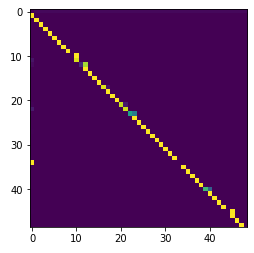


Layer 1 head 4 attentions

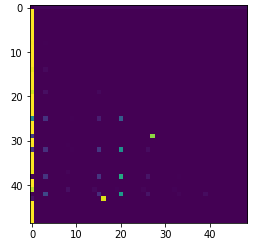

In [23]:
def compute_attention_terms(sentence, layer, head):
    """Input of shape: batch_size seq_len"""
    token_embedding = model.token_embedding(sentence)
    
    # Get the positions, then index into the position embedding
    seq_len = sentence.shape[1]
    pos_inds = torch.arange(seq_len).unsqueeze(0)
    pos_embedding = model.pos_embedding(pos_inds)
        
    aggregated = 0
    
    for l in range(layer):
        token_embedding += model.blocks[l](token_embedding, model.pos_embedding)
    
    for query_embedding in (token_embedding, pos_embedding):
        for key_embedding in (token_embedding, pos_embedding):
            query = model.blocks[layer].project_qkv(query_embedding)[:, :, :256]
            key = model.blocks[layer].project_qkv(key_embedding)[:, :, 256:512]

            # reshape
            num_heads = 8
            query = einops.rearrange(query, 'batch seq_len (num_heads head_size) -> batch num_heads seq_len head_size', num_heads=num_heads)
            key = einops.rearrange(key, 'batch seq_len (num_heads head_size) -> batch num_heads seq_len head_size', num_heads=num_heads)
            
            # Extract the desired Q and K matrices
            # Each matrix: seq_len, hidden size
            result = torch.einsum('b h q c, b h k c -> b h q k', query, key)
            # Want to get embedding1 in Q space, and embedding2 in K space
            
            result = result[0][head] # head 0
            result = torch.tril(result)

            print('shape:', result.shape)
            # print('mean:', torch.mean(result).detach())
            # Compute variance across token pairs
            # print('var:', torch.var(result, unbiased=False).detach().item())
            
            for y in range(10):
                l = []
                for x in range(10):
                    l.append(f'{result[y, x].item():8.2}')
                # print(' '.join(l))
            print(plt.imshow(torch.nn.Softmax(dim=-1)(result)[:,:].detach()))
            plt.show()
            
            print()
            aggregated += result
    print('aggregated')
    print('shape:', aggregated.shape)
    print('mean:', torch.mean(aggregated).detach())
    # Compute variance across token pairs
    print('var:', torch.var(aggregated, unbiased=False).detach().item())
    plt.imshow(torch.nn.Softmax(dim=-1)(aggregated)[:,:].detach())
    plt.show()
    
    # TODO: Compute variance across sentences (i.e. across the batch)
    
sentences = ['''[BEGIN] We dog eating ice cream. We dog in the park. We dog playing basketball. We dog throwing a baseball. We dog learning about machine learning. We dog trying to debug. We dog confused. We dog playing with the visualizer.''']
tokens = tokenizer(sentences)['input_ids']
print(f"{tokenizer.decode([tokens[0][7], tokens[0][2]])=}")

tokenizer.decode([tokens[0][7], tokens[0][2]])=' We dog'


shape: torch.Size([49, 49])
AxesImage(54,36;334.8x217.44)


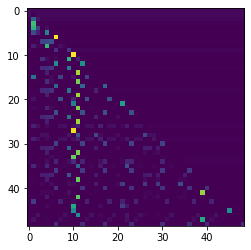


shape: torch.Size([49, 49])
AxesImage(54,36;334.8x217.44)


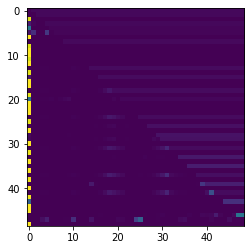


shape: torch.Size([49, 49])
AxesImage(54,36;334.8x217.44)


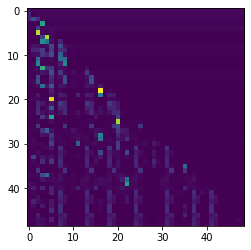


shape: torch.Size([49, 49])
AxesImage(54,36;334.8x217.44)


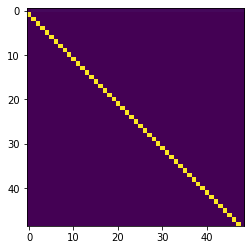


aggregated
shape: torch.Size([49, 49])
mean: tensor(-5.5161)
var: 240.6231689453125


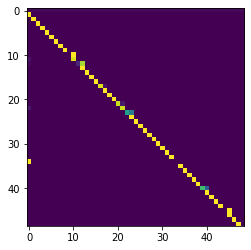

In [24]:
compute_attention_terms(torch.tensor(tokens, dtype=torch.long), layer=0, head=0)

# Are the position most interested in those that are at index one more than the key?

shape: torch.Size([49, 49])
AxesImage(54,36;334.8x217.44)


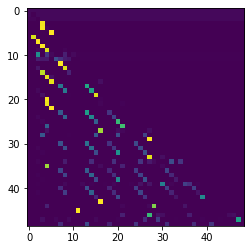


shape: torch.Size([49, 49])
AxesImage(54,36;334.8x217.44)


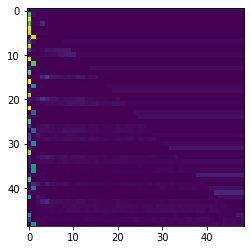


shape: torch.Size([49, 49])
AxesImage(54,36;334.8x217.44)


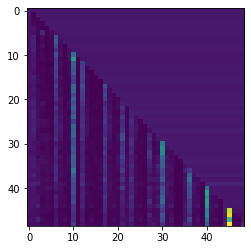


shape: torch.Size([49, 49])
AxesImage(54,36;334.8x217.44)


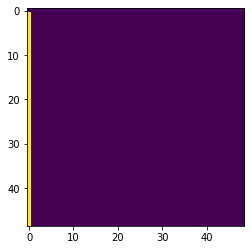


aggregated
shape: torch.Size([49, 49])
mean: tensor(-0.4866)
var: 63.597373962402344


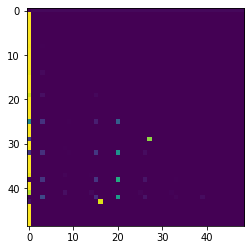

In [25]:
compute_attention_terms(torch.tensor(tokens, dtype=torch.long), layer=1, head=4)

# Are the position most interested in those that are at index one more than the key?

We also attempt to observe virtual heads, which are possible due to the residual stream in transformers. We observe that for queries "We", a lot of attention is paid to the previous instances of tokens that have appeared after "We" (i.e. dog).

The query "We" (in **bold**) pays attention to the key tokens "dog" (***italicized and in bold***):
> "[BEGIN] We ***dog*** eating ice cream. We ***dog*** in the park. We ***dog*** playing basketball. We ***dog*** throwing a baseball. **We** dog learning about machine learning. We dog trying to debug. We dog confused. We dog playing with the visualizer."

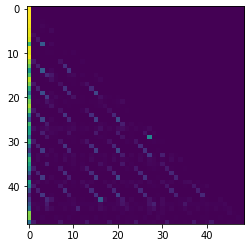

In [13]:
def virtual_head(tokens, layer0_head_idx, layer1_head_idx, model):
    # embedding.shape = [batch, seq_len, hidden_size]
    # precompute the attention matrices
    # A = softmax(((emb * Q)^T * K * emb) / sqrt(d))
    
    def get_attention_and_ov_matrix(token_emb, layer, head_idx):
        
        pos_ids = torch.arange(token_emb.shape[1]).unsqueeze(0)
        emb = model.pos_embedding(pos_ids) + token_emb
        query = model.blocks[layer].project_qkv(emb)[:, :, :256]
        key = model.blocks[layer].project_qkv(emb)[:, :, 256:512]
        # val = model.blocks[layer].project_qkv(emb)[:, :, 512:]
        
        # reshape
        num_heads = 8
        query = einops.rearrange(query, 'batch seq_len (num_heads head_size) -> batch num_heads seq_len head_size', num_heads=num_heads)
        key = einops.rearrange(key, 'batch seq_len (num_heads head_size) -> batch num_heads seq_len head_size', num_heads=num_heads)
        # val = einops.rearrange(val, 'batch seq_len (num_heads head_size) -> batch num_heads seq_len head_size', num_heads=num_heads)

        attn = torch.einsum('b h q c, b h k c -> b h q k', query, key)
        # Want to get embedding1 in Q space, and embedding2 in K space

        attn = attn[0][head_idx] # batch 0

        seq_len = emb.shape[1] # (batch, seq, hidden_size)
        mask = torch.tensor(torch.triu(torch.ones(seq_len, seq_len), diagonal=1), dtype=torch.bool)
        attn[mask] = -1000000
        attn /= math.sqrt(query.shape[-1])
        # For each query, we have a probability distribution over keys
        attn = torch.nn.Softmax(dim=-1)(attn)
        
        ## get ov ###
        # project_qkv.weight should be a 768x768 matrix (hidden_size=768)
        print(model.blocks[layer].project_qkv.weight.shape)
        # ... V
        val_mat = model.blocks[layer].project_qkv.weight[512:,:]
        print(val_mat.shape)
        val_mat = einops.rearrange(val_mat, '(num_heads head_size) hidden_size -> num_heads hidden_size head_size', num_heads=num_heads)
        
        print(val_mat.shape)
        val_mat = val_mat[head_idx]  # now shape = (hidden_size, head_size)
        print(val_mat.shape)
        head_size = 256//num_heads
        output = model.blocks[layer].project_output.weight[:, head_size*head_idx:head_size*(head_idx+1)]
        output = einops.rearrange(output, 'hidden_size head_size -> head_size hidden_size')
        # val_head: hidden_size head_size
        # output: head_size, hidden_size??
        # softmax(...)V W_O
        ov = val_mat @ output
        
        # OV emb
        return attn, ov
    
    ##### lAYER 0 ######
    token_embedding = model.token_embedding(tokens)
    attn0, ov0 = get_attention_and_ov_matrix(token_embedding, 0, layer0_head_idx)
    # (seq_len seq_len), (seq_len, hidden_size)
    
    ##### LAYER 1 ######
    emb = token_embedding + model.blocks[0](token_embedding, model.pos_embedding)
    attn1, ov1 = get_attention_and_ov_matrix(emb, 1, layer1_head_idx)
    plt.imshow(attn0.detach())
    plt.show()
    plt.imshow(attn1.detach())

    # token_embedding: batch_size, seq_len, embedding_size (probs hidden_size?)
    # attn0: seq_len, seq_len
    # ov0: hidden_size, hidden_size=c
    emb1 = torch.einsum('b k c, q k, c d -> b q d', token_embedding, attn0, ov0)
    emb2 = torch.einsum('b k c, q k, c d -> b q d ', emb1+token_embedding, attn1, ov1)
    # We want: seq_len, hidden_size
    logits = torch.einsum('bnl, vl -> bnv', emb2, model.token_embedding.weight)
    # multiply by the relevant model_weights, and the embedding to get the vocab logits
    _, tokens = torch.topk(logits, k=10, dim=-1)
    # We want: seq_len, vocab_size for each pair of heads
    return [(i, x) for i, x in enumerate(tokenizer.batch_decode(tokens[0]))]

[BEGIN] We dog eating ice cream. We dog in the park. We dog playing basketball. We dog throwing a baseball. We dog learning about machine learning. We dog trying to debug. We dog confused. We dog playing with the visualizer.


/tmp/ipykernel_4052714/3985420985.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(torch.triu(torch.ones(seq_len, seq_len), diagonal=1), dtype=torch.bool)


torch.Size([768, 256])
torch.Size([256, 256])
torch.Size([8, 256, 32])
torch.Size([256, 32])
torch.Size([768, 256])
torch.Size([256, 256])
torch.Size([8, 256, 32])
torch.Size([256, 32])


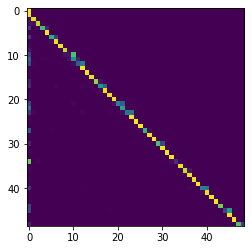

[(0, 'ationalmitteddaybornNovemberweightarbonnik Mandatoryachy'),
 (1, 'ationalborndayNovembermittedarbonweight Mandatorygennik'),
 (2, 'ationaldaymittedbornNovemberweightarbon Mandatorynikachy'),
 (3, 'day Earlyational Bynikmitted LateweightEarly Modern'),
 (4, ' Early Modern By Lateday Nevertheless MichaelnikEarlyational'),
 (5,
  ' November Federal October January Decemberachy Nevertheless Late Courtbo'),
 (6, 'WewebornyoubefiWashingtonnewReutersOur'),
 (7, ' dog Dog Progressivept Teen Marshal Michael Modern child pet'),
 (8,
  ' eating owning buying Wo ticking esche Eating earning skipping recovering'),
 (9, ' MichaelReutersbornWashingtonday Latecomweight EarlyOctober'),
 (10, ' MichaeldayReuters ProgressiveachyWashington Modernborn Lateweight'),
 (11, 'borndayNovemberReutersationalweightOctoberAFPWashingtoncom'),
 (12, 'WeweGurepguyouOurIntroduinfgre'),
 (13, ' dog Dog pet nat MarshalDog quad dogs canine detective'),
 (14,
  ' eating recovering storing occupying esche ate buying s

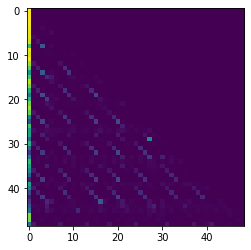

In [14]:
print(tokenizer.decode(tokens[0]))
virtual_head(torch.tensor(tokens, dtype=torch.long), 0, 4, model)